In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('hvac_data_cleaned.csv')

# FEATURE SELECTION & SCALING

In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
hour = df['timestamp'].dt.hour
day_of_week = df['timestamp'].dt.dayofweek

df['hour_sin'] = np.sin(2 * np.pi * hour / 24.0)
df['hour_cos'] = np.cos(2 * np.pi * hour / 24.0)

df['day_sin'] = np.sin(2 * np.pi * day_of_week / 7.0)
df['day_cos'] = np.cos(2 * np.pi * day_of_week / 7.0)

features = [
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 
    'outside_temp', 'ambient_temp', 'ambient_humidity', 
    'summer_SP_temp', 'winter_SP_temp', 'co2_1', 
    'on_off', 'damper', 'active_power']
df_selected = df[features].dropna()

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_selected)

In [4]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), :]) 
        y.append(data[i + sequence_length, -1])    
    return np.array(X), np.array(y)

sequence_length = 60 
X, y = create_sequences(scaled_data, sequence_length)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Data Shape: {X_train.shape}")

Data Shape: (20164, 60, 13)


# LSTM Architecture

In [5]:
model = Sequential()

# The first LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# The second LSTM layer
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))

# The output condenser
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1)) 

# Compile the brain
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/opt/anaconda3/envs/data/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,929 (128.63 KB)

 Trainable params: 32,929 (128.63 KB)

 Non-trainable params: 0 (0.00 B)

# Training the Model

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5,               
    restore_best_weights=True)

print("Starting training process with Early Stopping...")
history = model.fit(
    X_train, y_train,
    epochs=50,             
    batch_size=32,         
    validation_split=0.2,  
    callbacks=[early_stop], 
    verbose=1)
print("Training Complete! The best weights have been restored.")

Starting training process with Early Stopping...
Epoch 1/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0138 - val_loss: 0.0371
Epoch 2/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0064 - val_loss: 0.0282
Epoch 3/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0048 - val_loss: 0.0173
Epoch 4/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0040 - val_loss: 0.0232
Epoch 5/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0035 - val_loss: 0.0228
Epoch 6/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0033 - val_loss: 0.0174
Epoch 7/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0031 - val_loss: 0.0214
Epoch 8/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0031 - val_loss: 0.0162
Epoch 9/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0029 - val_loss: 0.0259
Epoch 10/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0028 - val_loss: 0.0161
Epoch 11/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0027 - val_loss:

# predicting the power consumption on the X_test data

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("Generating predictions...")
predictions = model.predict(X_test)
dummy_pred = np.zeros((len(predictions), X_train.shape[2]))
dummy_pred[:, -1] = predictions[:, 0]
real_predictions = scaler.inverse_transform(dummy_pred)[:, -1]

dummy_actual = np.zeros((len(y_test), X_train.shape[2]))
dummy_actual[:, -1] = y_test
real_actuals = scaler.inverse_transform(dummy_actual)[:, -1]

Generating predictions...
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


# PLOTING THE RESULT

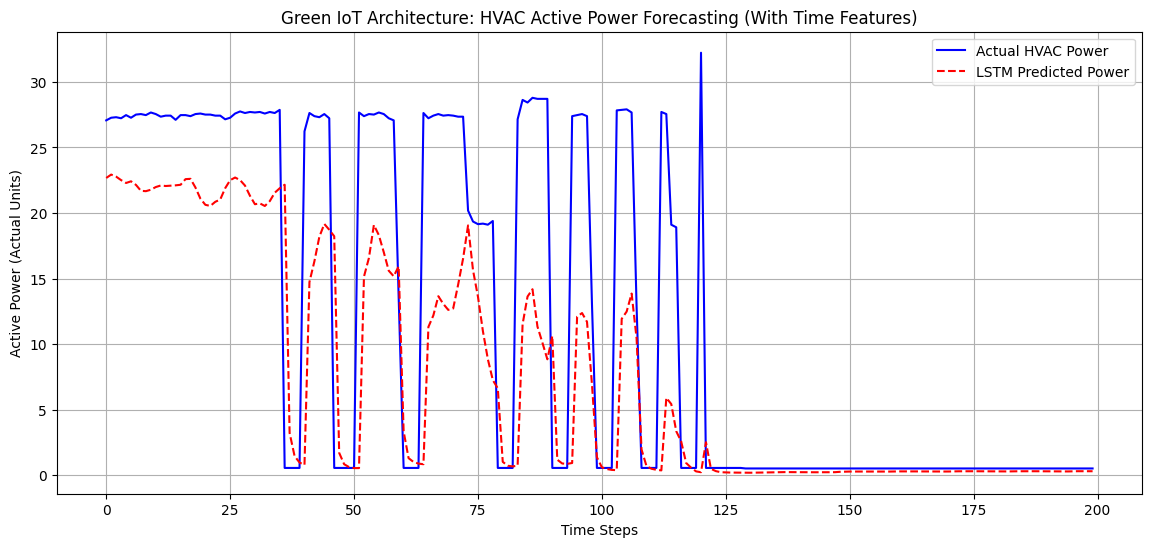

In [8]:
plt.figure(figsize=(14, 6))
plt.plot(real_actuals[:200], color='blue', label='Actual HVAC Power')
plt.plot(real_predictions[:200], color='red', linestyle='dashed', label='LSTM Predicted Power')
plt.title('Green IoT Architecture: HVAC Active Power Forecasting (With Time Features)')
plt.xlabel('Time Steps')
plt.ylabel('Active Power (Actual Units)')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(real_actuals, real_predictions)
rmse = np.sqrt(mean_squared_error(real_actuals, real_predictions))
mape = np.mean(np.abs((real_actuals - real_predictions) / (real_actuals + 1e-10))) * 100
print("NEW MODEL ACCURACY METRICS")
print("-" * 30)
print(f"Mean Absolute Error (MAE): {mae:.2f} units")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} units")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

NEW MODEL ACCURACY METRICS
------------------------------
Mean Absolute Error (MAE): 3.48 units
Root Mean Squared Error (RMSE): 6.70 units
Mean Absolute Percentage Error (MAPE): 69.22%


# SAVE ARTIFACTS FOR DEPLOYMENT

In [10]:
import pickle
print("Saving model and scaler for deployment...")

model.save('hvac_lstm_model.h5')
with open('hvac_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Deployment Artifacts ('hvac_lstm_model.h5' & 'hvac_scaler.pkl') saved successfully!")

Saving model and scaler for deployment...
Deployment Artifacts ('hvac_lstm_model.h5' & 'hvac_scaler.pkl') saved successfully!
